In [0]:
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://apache.osuosl.org/spark/spark-2.2.1/spark-2.2.1-bin-hadoop2.7.tgz
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
# !tar xf https://www-eu.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Set environmental variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark.sql.functions import mean, desc

In [0]:
spark

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-04.csv

--2018-12-09 19:09:04--  https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-04.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 821249453 (783M) [text/csv]
Saving to: ‘yellow_tripdata_2018-04.csv.2’

yellow_tripdata_201 100%[===================>] 783.20M  19.6MB/s    in 30s     

2018-12-09 19:09:35 (25.9 MB/s) - ‘yellow_tripdata_2018-04.csv.2’ saved [821249453/821249453]



In [0]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2018-04.csv

--2018-12-09 19:09:35--  https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2018-04.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71636786 (68M) [text/csv]
Saving to: ‘green_tripdata_2018-04.csv’

green_tripdata_2018 100%[===================>]  68.32M  34.5MB/s    in 2.0s    

2018-12-09 19:09:38 (34.5 MB/s) - ‘green_tripdata_2018-04.csv’ saved [71636786/71636786]



In [0]:
yellow = spark.read.csv("yellow_tripdata_2018-04.csv", header=True, inferSchema=True)

In [0]:
green = spark.read.csv("green_tripdata_2018-04.csv", header=True, inferSchema=True)

In [0]:
print((yellow.count(), len(yellow.columns)))

(9305515, 17)


In [0]:
print((green.count(), len(green.columns)))

(800084, 19)


## Yellow Cleaning

In [0]:
yellow = yellow.drop("tpep_pickup_datetime", "tpep_dropoff_datetime")
from pyspark.sql.functions import isnan, when, count, col
yellow.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in yellow.columns]).show()

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         0|           0|                    0|           0|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+



In [0]:
yellow = yellow.filter(yellow["trip_distance"]<100)

In [0]:
yellow = yellow.filter(yellow["trip_distance"]<10)

In [0]:
yellow = yellow.filter(yellow["fare_amount"] > 2.5)

In [0]:
yellow = yellow.filter(yellow["fare_amount"] < 29.5)

In [0]:
yellow = yellow.filter(yellow["RatecodeID"] != 99)

In [0]:
print((yellow.count(), len(yellow.columns)))

(8525678, 15)


In [0]:
yellow.describe().show()

+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+-------------------+---------------------+------------------+
|summary|          VendorID|   passenger_count|     trip_distance|         RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|      fare_amount|             extra|             mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+-------------------+---------------------+------------------+
|  count|           8525678|           8525678|           8525678|            8525678|           

## Green Cleaning

In [0]:
# Drop column with all NULL values
green = green.drop("ehail_fee")
type(green)
#green.na.drop().show()

# Filter out null values
green = green.filter(green.trip_type.isNotNull())
print((green.count(), len(green.columns)))

(800083, 18)


In [0]:
from pyspark.sql import functions as F
timeFmt = "yyyy-MM-dd'T'HH:mm:ss.SSS"
timeDiff = (F.unix_timestamp('lpep_dropoff_datetime', format=timeFmt)
            - F.unix_timestamp('lpep_pickup_datetime', format=timeFmt))
green = green.withColumn("Duration", timeDiff/60)

In [0]:
cols = ['duration']
bounds = {}
for col in cols:
 quantiles = green.approxQuantile(
     col, [0.25, 0.75], 0.05
 )
 IQR = quantiles[1] - quantiles[0]
 bounds[col] = [
     quantiles[0] - 1.5 * IQR,
     quantiles[1] + 1.5 * IQR
 ]
bounds

{'duration': [-11.574999999999998, 35.69166666666666]}

In [0]:
green = green.filter((green["Duration"]  > 0) & (green["Duration"] < bounds['duration'][1]))

In [0]:
from pyspark.sql.functions import date_format
date = green.select('lpep_pickup_datetime', date_format('lpep_pickup_datetime', 'H').alias('hour'), date_format('lpep_pickup_datetime', 'd').alias('date'), date_format('lpep_pickup_datetime', 'u').alias('day_number'), date_format('lpep_pickup_datetime', 'E').alias('day'))
#green.show()
date = date.withColumn('is_weekend',when((date.day == 'Sun') | (date.day == 'Sat'),1).otherwise(0))
# Convert string to numeric

from pyspark.sql.types import IntegerType
date = date.withColumn("hour", date["hour"].cast(IntegerType()))
date = date.withColumn("date", date["date"].cast(IntegerType()))
date = date.withColumn("day_number", date["day_number"].cast(IntegerType()))
date = date.withColumn("is_weekend", date["is_weekend"].cast(IntegerType()))

In [0]:
from pyspark.sql.functions import monotonically_increasing_id
green1 =green.drop("lpep_pickup_datetime")
green1 = green1.withColumn("id", monotonically_increasing_id())
#df = df.drop("address")
date1 = date.withColumn("id", monotonically_increasing_id())

green1.show()

date1.show()

joined1 = date1.join(green1, "id", "outer").drop("id")

joined1.show()

+--------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+------------------+---+
|VendorID|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|payment_type|trip_type|          Duration| id|
+--------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------------------+------------+------------+---------+------------------+---+
|       2|  2018-04-01 01:01:33|                 N|         1|          80|         256|              1|         0.91|        6.0|  0.5|    0.5|       0.0|         0.0|                  0.3|         7.3|           2|        1| 5.816666666666666|  0|


# (From Yellow)

(array([2327160., 3125287., 1421133.,  670673.,  366434.,  234319.,
         154720.,  104494.,   79484.,   41974.]),
 array([0.   , 0.999, 1.998, 2.997, 3.996, 4.995, 5.994, 6.993, 7.992,
        8.991, 9.99 ]),
 <a list of 10 Patch objects>)

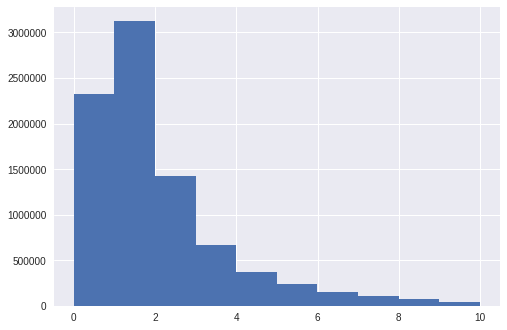

In [0]:
import matplotlib.pyplot as plt
# Show histogram of the 'C1' column
bins, counts = yellow.select('trip_distance').rdd.flatMap(lambda x: x).histogram(10)


plt.hist(bins[:-1], bins=bins, weights=counts)

(array([7.43553e+05, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0.  ,  48.28,  96.56, 144.84, 193.12, 241.4 , 289.68, 337.96,
        386.24, 434.52, 482.8 ]),
 <a list of 10 Patch objects>)

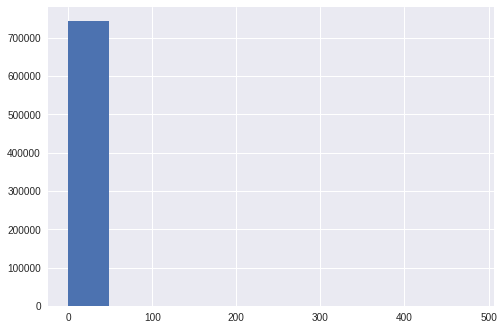

In [0]:
bins, counts = green_new.select('trip_distance').rdd.flatMap(lambda x: x).histogram(10)


plt.hist(bins[:-1], bins=bins, weights=counts)

(array([3428408., 3133515., 1185831.,  484632.,  293292.]),
 array([ 2.52 ,  7.876, 13.232, 18.588, 23.944, 29.3  ]),
 <a list of 5 Patch objects>)

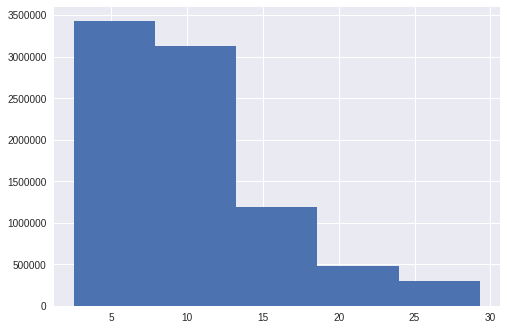

In [0]:
bins, counts = yellow.select('fare_amount').rdd.flatMap(lambda x: x).histogram(5)


plt.hist(bins[:-1], bins=bins, weights=counts)

(array([7.43554e+05, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ -200.   ,  1929.168,  4058.336,  6187.504,  8316.672, 10445.84 ]),
 <a list of 5 Patch objects>)

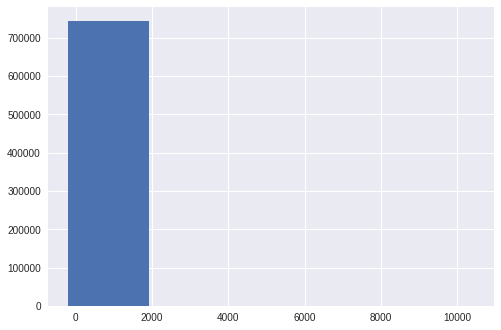

In [0]:
bins, counts = green_new.select('fare_amount').rdd.flatMap(lambda x: x).histogram(5)


plt.hist(bins[:-1], bins=bins, weights=counts)

{'boxes': [<matplotlib.lines.Line2D at 0x7f03f9d0d160>],
 'caps': [<matplotlib.lines.Line2D at 0x7f03f9d0dc18>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f03f9c96978>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f03f9c96518>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f03f9d0d2e8>,
  <matplotlib.lines.Line2D at 0x7f03f9d0d7b8>]}

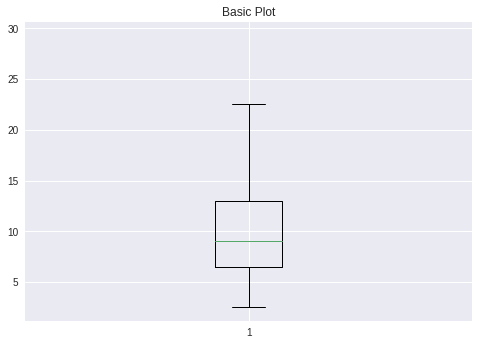

In [0]:
# BoxPlot
d2 = yellow.select('fare_amount').rdd.flatMap(lambda x: x).collect()
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(d2)


{'boxes': [<matplotlib.lines.Line2D at 0x7f0406339fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f0406344ac8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f040634d828>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f040634d3c8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f0406344198>,
  <matplotlib.lines.Line2D at 0x7f0406344668>]}

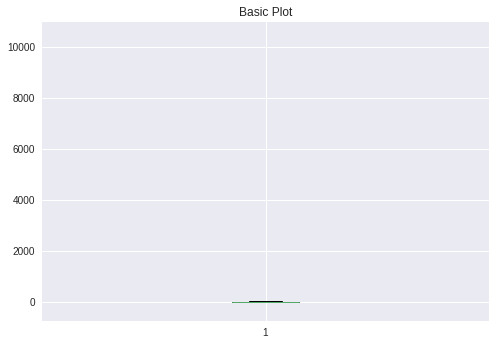

In [0]:
d2 = green_new.select('fare_amount').rdd.flatMap(lambda x: x).collect()
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(d2)


+-------------+-----------+
|trip_distance|fare_amount|
+-------------+-----------+
|          6.7|       22.5|
|          4.1|       15.5|
|          0.7|        5.5|
|          2.5|       11.5|
|          1.8|        8.5|
+-------------+-----------+
only showing top 5 rows



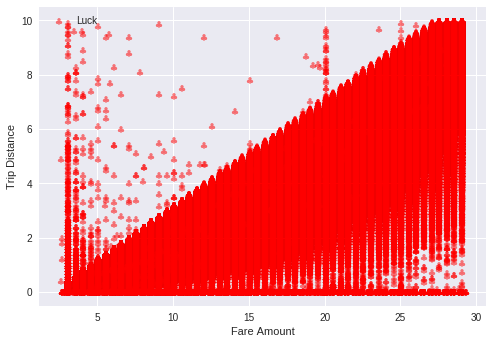

In [0]:
#Scatterplot
scar = yellow.select('trip_distance','fare_amount')
scar.show(5)
s1 = scar.select('fare_amount').rdd.flatMap(lambda x: x).collect()
s2 = scar.select('trip_distance').rdd.flatMap(lambda x: x).collect()
plt.scatter(s1,s2, alpha = 0.5, color = 'red', cmap='viridis', marker=r'$\clubsuit$', label="Luck")
plt.xlabel('Fare Amount')
plt.ylabel('Trip Distance')
plt.legend(loc='upper left')
plt.show()

+-------------+-----------+
|trip_distance|fare_amount|
+-------------+-----------+
|         1.75|        9.5|
|         14.3|       42.0|
|          1.2|        6.5|
|         4.32|       14.5|
|         5.31|       19.5|
+-------------+-----------+
only showing top 5 rows



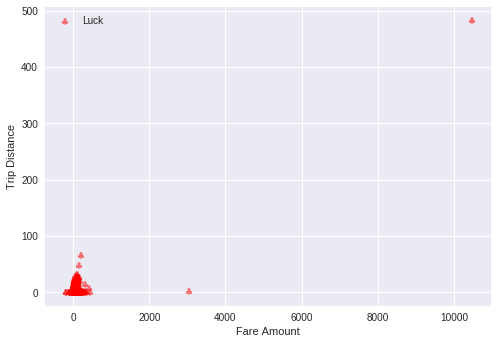

In [0]:
scar = green_new.select('trip_distance','fare_amount')
scar.show(5)
s1 = scar.select('fare_amount').rdd.flatMap(lambda x: x).collect()
s2 = scar.select('trip_distance').rdd.flatMap(lambda x: x).collect()
plt.scatter(s1,s2, alpha = 0.5, color = 'red', cmap='viridis', marker=r'$\clubsuit$', label="Luck")
plt.xlabel('Fare Amount')
plt.ylabel('Trip Distance')
plt.legend(loc='upper left')
plt.show()

In [0]:
## 

## (From Green) 

In [0]:
joined1.groupBy('store_and_fwd_flag').count().show()
joined1.groupBy('passenger_count').count().show()
joined1.groupBy('trip_type').count().show()
joined1.groupBy('RatecodeID').count().show()
joined1.groupBy('payment_type').count().show()
joined1.groupBy('VendorID').count().show()

+------------------+------+
|store_and_fwd_flag| count|
+------------------+------+
|                 Y|   999|
|                 N|742557|
+------------------+------+

+---------------+------+
|passenger_count| count|
+---------------+------+
|              1|625897|
|              6| 14514|
|              3| 12851|
|              5| 25143|
|              9|     3|
|              4|  4200|
|              8|    10|
|              7|    13|
|              2| 59925|
|              0|  1000|
+---------------+------+

+---------+------+
|trip_type| count|
+---------+------+
|        1|732029|
|        2| 11527|
+---------+------+

+----------+------+
|RatecodeID| count|
+----------+------+
|         1|731579|
|         6|    10|
|         3|   190|
|         5| 10676|
|         4|   323|
|         2|   778|
+----------+------+

+------------+------+
|payment_type| count|
+------------+------+
|           1|407245|
|           3|  3580|
|           5|    28|
|           4|  2014|
|         

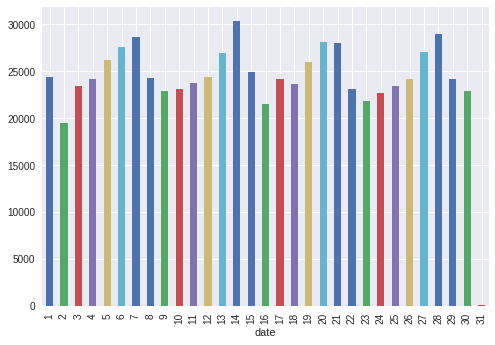

In [0]:
import pandas

# Create dataframe with frequencies with date
date_plot = joined1.groupBy('date').count()
# Convert the dataframe to pandas dataframe
date_plot = date_plot.toPandas()
# Set the date column as index
date_plot =date_plot.set_index('date')
# Sort the dataframe according to inndex
date_plot.sort_index(inplace=True)
# Plot the box plot
date_plot.T.squeeze().plot.bar()

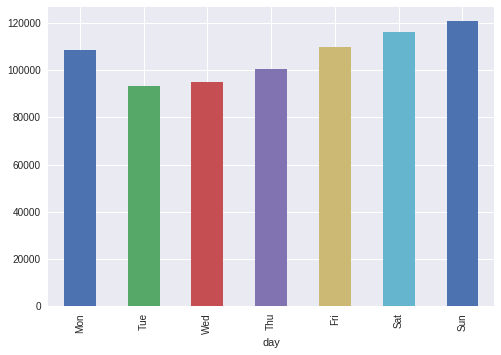

In [0]:
# Create dataframe with frequencies with day
day_plot = joined1.groupBy('day','day_number').count()
# Convert the dataframe to pandas dataframe
day_plot = day_plot.toPandas()

# Sort the dataframe based on the day
day_plot.sort_values("day_number", inplace=True)

# Drop the column day_number
day_plot=day_plot.drop('day_number',axis=1)

# Set the day column as index
day_plot =day_plot.set_index('day')

#day_plot.sort_index(inplace=True)
# Plot the box plot
day_plot.T.squeeze().plot.bar()

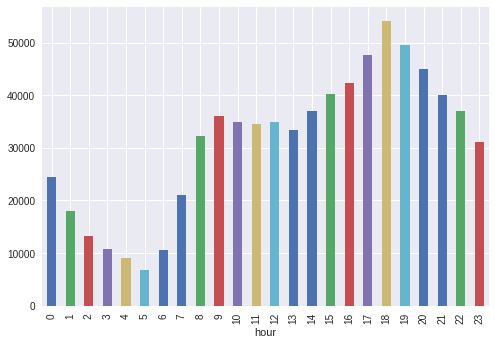

In [0]:
# Create dataframe with frequencies with date
hour_plot = joined1.groupBy('hour').count()
# Convert the dataframe to pandas dataframe
hour_plot = hour_plot.toPandas()
# Set the hour column as index
hour_plot =hour_plot.set_index('hour')
# Sort the dataframe according to inndex
hour_plot.sort_index(inplace=True)
# Plot the box plot
hour_plot.T.squeeze().plot.bar()

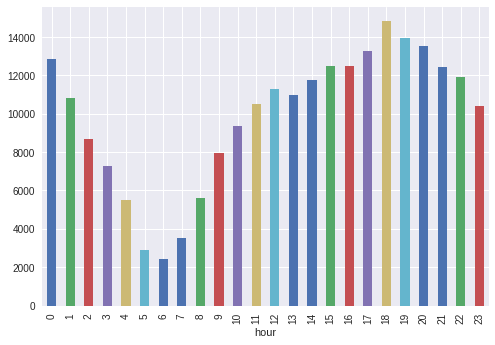

In [0]:
## df.filter(df["age"]>24)

# Create dataframe with frequencies with date
hour_plot = joined1.filter(joined1["is_weekend"]== 1)
hour_plot = hour_plot.groupBy('hour').count()

# Convert the dataframe to pandas dataframe
hour_plot = hour_plot.toPandas()
# Set the hour column as index
hour_plot =hour_plot.set_index('hour')
# Sort the dataframe according to inndex
hour_plot.sort_index(inplace=True)
# Plot the box plot
hour_plot.T.squeeze().plot.bar()

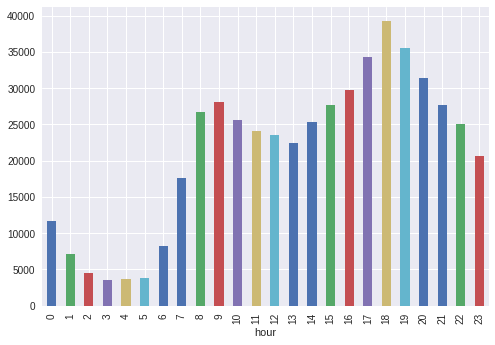

In [0]:
## df.filter(df["age"]>24)

# Create dataframe with frequencies with date
hour_plot = joined1.filter(joined1["is_weekend"]== 0)
hour_plot = hour_plot.groupBy('hour').count()

# Convert the dataframe to pandas dataframe
hour_plot = hour_plot.toPandas()
# Set the hour column as index
hour_plot =hour_plot.set_index('hour')
# Sort the dataframe according to inndex
hour_plot.sort_index(inplace=True)
# Plot the box plot
hour_plot.T.squeeze().plot.bar()

## Insights

In [0]:
yellow.groupBy('tip_amount').count().show()

+----------+-----+
|tip_amount|count|
+----------+-----+
|      2.86|39134|
|      3.26|26180|
|      0.66|  330|
|     10.65|   84|
|     194.7|    1|
|     23.04|    1|
|     12.32|    1|
|     65.78|    1|
|      15.5|   10|
|      56.8|    1|
|      9.13|    2|
|      13.4|    2|
|      1.82|19149|
|      5.86| 3190|
|      9.55|    3|
|     24.42|    1|
|      6.96|    1|
|      5.05| 5599|
|      0.07|  203|
|      0.84|  163|
+----------+-----+
only showing top 20 rows



In [0]:
yellow.describe('tip_amount').show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|           8525678|
|   mean|1.4963820801120402|
| stddev|1.5769073816895547|
|    min|               0.0|
|    max|             410.0|
+-------+------------------+



In [0]:
yellow.groupBy('tip_amount','DOLocationID').count().orderBy('tip_amount',ascending = False ).show()

+----------+------------+-----+
|tip_amount|DOLocationID|count|
+----------+------------+-----+
|     410.0|         209|    1|
|     300.0|         107|    1|
|     222.0|         211|    1|
|    220.22|         114|    1|
|     220.0|         140|    1|
|     200.0|         231|    1|
|     200.0|         246|    1|
|     200.0|          48|    1|
|     194.7|         130|    1|
|     190.7|         130|    1|
|     189.2|         216|    1|
|     155.0|         233|    1|
|    151.38|         237|    1|
|     150.0|         166|    1|
|     120.0|         182|    1|
|    115.55|         137|    1|
|    111.82|          57|    1|
|    111.66|         249|    1|
|     111.0|         237|    1|
|    110.01|          50|    1|
+----------+------------+-----+
only showing top 20 rows



In [0]:
yellow.groupby("DOLocationID").agg(mean("Tip_amount"),count("DOLocationID")).filter(count("DOLocationID") > 99999).sort(desc("avg(Tip_amount)")).show()

+------------+------------------+-------------------+
|DOLocationID|   avg(Tip_amount)|count(DOLocationID)|
+------------+------------------+-------------------+
|         231|1.7786163953313097|             145822|
|         262|  1.57687923458419|             116747|
|         263|1.5389507015211972|             169275|
|          79| 1.505593460917256|             204310|
|         140|1.4975377613158474|             159290|
|         246| 1.494008972594714|             162049|
|         249|1.4871651535244386|             147045|
|         238| 1.486356821192059|             188750|
|         113| 1.450420094122459|             127281|
|         234|1.4488993991361738|             250972|
|         233|1.4455697859432757|             127583|
|         264|1.4445461016019006|             116612|
|         239|1.4368791372524476|             222823|
|         143|1.4360167652692866|             117982|
|         162|1.4346122304189088|             262166|
|         107|1.420056665098